In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os, glob

데이터 불러오기

In [2]:
# 폴더 불러오기
filepath='./newHAND/'
files=glob.glob(filepath+'*')
files

['./newHAND\\J1',
 './newHAND\\J10',
 './newHAND\\J11',
 './newHAND\\J12',
 './newHAND\\J13',
 './newHAND\\J14',
 './newHAND\\J2',
 './newHAND\\J3',
 './newHAND\\J4',
 './newHAND\\J5',
 './newHAND\\J6',
 './newHAND\\J7',
 './newHAND\\J8',
 './newHAND\\J9',
 './newHAND\\M1',
 './newHAND\\M10',
 './newHAND\\M11',
 './newHAND\\M12',
 './newHAND\\M13',
 './newHAND\\M14',
 './newHAND\\M15',
 './newHAND\\M16',
 './newHAND\\M17',
 './newHAND\\M2',
 './newHAND\\M3',
 './newHAND\\M4',
 './newHAND\\M5',
 './newHAND\\M6',
 './newHAND\\M7',
 './newHAND\\M8',
 './newHAND\\M9']

In [3]:
data_list = []
label_list = []
label_Dict={

    'J1': 0, 'J2': 1, 'J3': 2, 'J4': 3, 'J5': 4, 'J6': 5, 'J7': 6, 'J8': 7, 'J9': 8, 'J10': 9,
    'J11': 10, 'J12': 11, 'J13': 12, 'J14': 13, 'M1': 14, 'M2': 15, 'M3': 16, 'M4': 17, 'M5': 18,
    'M6': 19, 'M7': 20, 'M8': 21, 'M9': 22, 'M10': 23, 'M11': 24, 'M12': 25, 'M13': 26, 'M14': 27,
    'M15': 28, 'M16': 29, 'M17': 30
}

for image_folder in files:
    imgs = glob.glob(image_folder + '/*')
    label = label_Dict[f'{image_folder[10:]}']

    for img_path in imgs:
        # 이미지 파일 읽기
        img = cv2.imread(img_path) #,cv2.IMREAD_GRAYSCALE
        data_list.append(img)
        label_list.append(label)

# 리스트를 NumPy 배열로 변환
imgNP = np.array(data_list).astype('uint8')     # 용량 많.astype('uint16')으면  # 써서 줄이기
label = np.array(label_list)

#스케일링
imgNP=imgNP/255    # 배경 흑백 하고 싶으면 (255-imgNP)

print(imgNP.shape, label.shape,imgNP.ndim)

(18228, 50, 50, 3) (18228,) 4


In [4]:
# 라벨 확인
np.unique(label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [5]:
# 라벨 원핫인코딩
from keras.utils import to_categorical
label_encoded=to_categorical(label)
label_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
# imgNP=imgNP.reshape(36456,100,100,1)
# imgNP.shape,imgNP.ndim

## 모델링 전처리

train / test 데이터 나누기

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_x,test_x,train_y,test_y=train_test_split(imgNP,label_encoded,stratify=label,test_size=0.2,random_state=10)

In [9]:
train_y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

모듈 불러오기

In [10]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPool2D,Activation
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler


In [15]:
# 모델 구현
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=(50,50,3),activation='relu'))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(31, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 16928)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2166912   
                                                      

In [16]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# (1) 학습 진행 중 모델 저장
M_PATH='./models/'

if not os.path.exists(M_PATH):
    os.mkdir(M_PATH)
    print('파일 생성')

M_FILE=M_PATH+'model_cnn_hand.hdf5'
mcCB=ModelCheckpoint(M_FILE,monitor='val_loss',verbose=True,save_best_only=True)

# (2) 모델 개선 여부 체크 후 조기종료 처리 콜백객체
esCB=EarlyStopping(patience=10,restore_best_weights=True)

# 학습에 사용될 값들
EPOCHS,BATCH_SIZE,VAL_SPLIT= 50,10,0.2

# (3) 에포크 마다 학습률 제어 콜백객체
def scheduler(epoch,lr):
    if epoch>20:
        return 0.00001
    else:return lr

# 초기에 높은 학습률로 시작하여 수렴하기 전에 점진적으로 낮추거나, 특정 시점에서 더 작은 값으로 변경하여 최적화 성능을 개선하는 데 사용됩니다.
lrCB=LearningRateScheduler(scheduler)

In [18]:
# 모델 실행
history=model.fit(
        train_x,train_y,
        epochs=EPOCHS,batch_size=BATCH_SIZE,
        validation_split=VAL_SPLIT,
        callbacks=[mcCB,esCB,lrCB]
)

Epoch 1/50
1167/1167 [==============================] - ETA: 0s - loss: 1.9261 - accuracy: 0.4263
Epoch 1: val_loss improved from inf to 0.48783, saving model to ./models\model_cnn_hand.hdf5
1167/1167 [==============================] - 33s 28ms/step - loss: 1.9261 - accuracy: 0.4263 - val_loss: 0.4878 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 2/50
   1/1167 [..............................] - ETA: 1:32 - loss: 0.6115 - accuracy: 0.8000

c:\Users\KDP-13\AppData\Local\anaconda3\envs\BY_YUNA_copy\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1167/1167 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8637
Epoch 2: val_loss improved from 0.48783 to 0.09237, saving model to ./models\model_cnn_hand.hdf5
1167/1167 [==============================] - 33s 28ms/step - loss: 0.4182 - accuracy: 0.8637 - val_loss: 0.0924 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 3/50
1166/1167 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9334
Epoch 3: val_loss improved from 0.09237 to 0.04358, saving model to ./models\model_cnn_hand.hdf5
1167/1167 [==============================] - 48s 41ms/step - loss: 0.2044 - accuracy: 0.9334 - val_loss: 0.0436 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 4/50
1166/1167 [============================>.] - ETA: 0s - loss: 0.1311 - accuracy: 0.9563
Epoch 4: val_loss improved from 0.04358 to 0.02166, saving model to ./models\model_cnn_hand.hdf5
1167/1167 [==============================] - 41s 35ms/step - loss: 0.1311 - accuracy: 0.9564 - val_loss: 0.0217 - val_accuracy: 0.

In [19]:
# 검증셋과 학습셋 오차 저장
y_vloss=history.history['val_loss']
y_loss=history.history['loss']

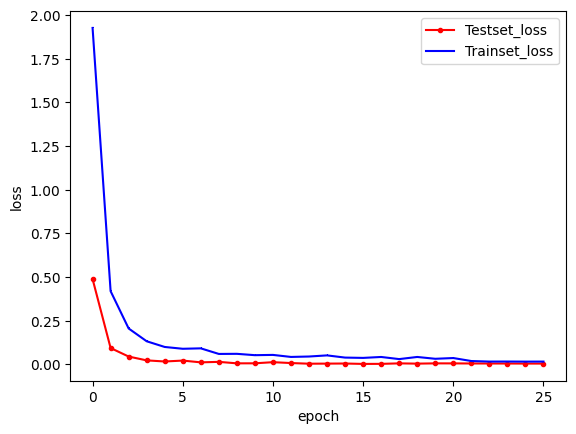

In [20]:
# 그래프로 loss 표시
x_len=np.arange(len(y_loss))
plt.plot(x_len,y_vloss,marker='.',c='red',label='Testset_loss')
plt.plot(x_len,y_loss,marker=',',c='blue',label='Trainset_loss')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [21]:
# 검증셋과 학습셋 정확도 저장
y_vAcu=history.history['val_accuracy']
y_Acu=history.history['accuracy']

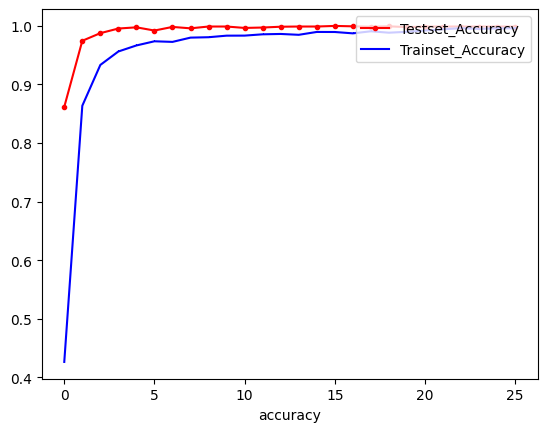

In [22]:
# 그래프로 Accuracy 표시
x_len=np.arange(len(y_loss))
plt.plot(x_len,y_vAcu,marker='.',c='red',label='Testset_Accuracy')
plt.plot(x_len,y_Acu,marker=',',c='blue',label='Trainset_Accuracy')

plt.legend(loc='upper right')
plt.xlabel('accuracy')
plt.ylabel('')
plt.show()

평가

In [24]:
score = model.evaluate(test_x, test_y)
print()
print('Score : ',score)
print()
print("Test Loss : ", score[0])
print()
print("Test Accuracy : ", score[1])

114/114 [==============================] - 1s 11ms/step - loss: 0.0025 - accuracy: 0.9992

Score :  [0.002537505002692342, 0.9991771578788757]

Test Loss :  0.002537505002692342

Test Accuracy :  0.9991771578788757
